In [1]:
from IPython.display import Image

# CNTK 105: Базовый автокодер (AE) с данными MNIST

**Предпосылки**: Мы предполагаем, что вы успешно загрузили данные MNIST, заполнив учебник под названием CNTK_103A_MNIST_DataLoader.ipynb.


## Введение

В этом уроке мы познакомим вас с основами [Autoencoders](https://en.wikipedia.org/wiki/Autoencoder). Автокодер - это искусственная нейронная сеть, используемая для неконтролируемого изучения эффективных кодировок. Другими словами, они используются для сжатия данных с потерями, которые изучаются автоматически вместо того, чтобы полагаться на человеческие инженерные функции. Целью автокодирования является изучение представления (кодирования) набора данных, как правило, с целью уменьшения размерности. 

Автокодеры очень специфичны для набора данных и не отличаются от стандартных кодеков, таких как JPEG, MPEG-кодированные кодировки. После того, как информация закодирована и декодируется до исходных измерений, в процессе теряется некоторая информация. Учитывая, что эти кодировки специфичны для данных, автокодеры не используются для сжатия. Тем не менее, есть две области, где автокодеры были очень эффективными: уменьшение шума и уменьшение размерности.

Автокендеры привлекают внимание, поскольку они давно считаются потенциальным подходом к неконтролируемому обучению. Поистине неконтролируемые подходы подразумевают изучение полезных представлений без необходимости использования меток. Автокодеры попадают под самоконтролируемое обучение, конкретный экземпляр контролируемого обучения, где цели генерируются из входных данных. 

**Цель** 

Наша цель состоит в том, чтобы обучить автокодер, который сжимает MNIST цифру изображения до вектора меньшего размера, а затем восстанавливает изображение. Данные MNIST содержат рукописные цифры с небольшим фоновым шумом.

In [2]:
# Рисунок 1
Image(url="http://cntk.ai/jup/MNIST-image.jpg", width=300, height=300)

В этом уроке мы будем использовать [MNIST рукописные цифры](https://en.wikipedia.org/wiki/MNIST_database), чтобы показать, как изображения могут быть закодированы и декодированы (восстановлены) с использованием сетей прямой пересылки. Мы визуализируем оригинальные и восстановленные изображения. Мы проиллюстрируем сеть подачи вперед на основе двух автокодеров: простого и глубокого автокодирования. Более продвинутые автокодеры будут рассмотрены в будущих учебниках серии 200.

In [3]:
# Import the relevant modules
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Import CNTK 
import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

%matplotlib inline

Существует два режима работы:
- *Быстрый режим*: `isFast` установлен на `True`. Это режим по умолчанию для ноутбуков, что означает, что мы тренируемся за меньшее количество итераций по ограниченным данным. Это обеспечивает функциональную корректность ноутбука, хотя выпущенные модели далеки от того, что могло бы произвести завершенное обучение.

- *Медленный режим*:  мы рекомендуем пользователю установить этот флаг в значение `False` , как только пользователь изучит ноутбук, и хочет получить представление о работе ноутбуков в течение более длительного периода с различными параметрами для обучения.

In [4]:
isFast = True

## Чтение данных

В этом разделе мы будем читать данные, сгенерированные в CNTK 103 Part A.

Данные находятся в следующем формате:

    |labels 0 0 0 0 0 0 0 1 0 0 |features 0 0 0 0 ... 
                                                  (784 integers each representing a pixel)
    
 В этом уроке мы будем использовать пиксели изображения, соответствующие целочисленному потоку с именем "features". Мы определяем функцию  `create_reader` для чтения данных обучения и тестирования с помощью [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html?highlight=ctfdeserializer#cntk.io.CTFDeserializer). Метки [1-hot encoded](https://en.wikipedia.org/wiki/One-hot). Мы игнорируем их в этом уроке. 

Мы также проверяем, загружен ли файл обучения и тестовых данных для чтения функцией `create_reader`. В этом уроке мы используем данные MNIST, которые вы загрузили, используя ноутбук CNTK_103A_MNIST_DataLoader. Набор данных содержит 60 000 обучающих изображений и 10 000 тестовых изображений, каждое изображение которых составляет 28 х 28 пикселей.

In [5]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels_viz = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features   = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [6]:
# Ensure the training and test data is generated and available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.
data_found = False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
print("Data directory is {0}".format(data_dir))


Data directory is data\MNIST


## Создание модели (Простой AE)

Мы начинаем с простой единой полностью подключенной сети прямого доступа в качестве энкодера и в качестве декодера (как показано на рисунке ниже):

In [7]:
# Рисунок 2
Image(url="http://cntk.ai/jup/SimpleAEfig.jpg", width=200, height=200)

Входные данные представляют собой набор ручных цифровых изображений, каждый из которых 28 х 28 пикселей. В этом уроке мы рассмотрим каждое изображение как линейный массив из 784 пиксельных значений. Эти пиксели рассматриваются как вход с 784 размерами, по одному на пиксель. Поскольку целью автокодера является сжатие данных и восстановление исходного изображения, выходной размер такой же, как и размер входного сигнала. Мы сжимаем входные данные до 32 измерений (называемых `encoding_dim`). Кроме того, поскольку максимальное входное значение равно 255, мы нормируем вход между 0 и 1. 

In [8]:
input_dim = 784
encoding_dim = 32
output_dim = input_dim

def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform()):
        # We scale the input pixels to 0-1 range
        encode = C.layers.Dense(encoding_dim, activation = C.relu)(features/255.0)
        decode = C.layers.Dense(input_dim, activation = C.sigmoid)(encode)

    return decode

### Обучение и тестирование модели

В предыдущих уроках мы определили каждую фазу обучения и тестирования отдельно. В этом уроке мы объединяем два компонента в одном месте, чтобы этот шаблон можно было использовать в качестве примера для использования.  

Функция `train_and_test`выполняет две основные задачи:
- Обучить модель
- Оценить точность модели по тестовым данным

Для тренировки:

> Функция принимает читателя (`reader_train`), модельную функцию (`model_func`)и целевую (a.k.a `label`) в качестве входных данных. В этом уроке мы покажем, как создать и передать **own**  свою функцию потери.  Мы нормализуем функцию `label`, чтобы иполучать значение между 0 и 1 для вычисления ошибки метки с помощью функции `C.classification_error`.

> Мы используем оптимизатор Adam [learners](https://www.cntk.ai/pythondocs/cntk.learner.html#module-cntk.learner) в этом учебном пособии из ряда доступных в наборе инструментов.  

Для тестирования:

> Функция дополнительно берет считыватель (`reader_test`) и оценивает предсказанные значения пикселей, сделанные моделью по сравнению с эталонными данными, в этом случае исходные значения пикселей для каждого изображения.


In [9]:
def train_and_test(reader_train, reader_test, model_func):
    
    ###############################################
    # Training the model
    ###############################################
    
    # Instantiate the input and the label variables
    input = C.input_variable(input_dim)
    label = C.input_variable(input_dim)
    
    # Create the model function
    model = model_func(input)
    
    # The labels for this network is same as the input MNIST image.
    # Note: Inside the model we are scaling the input to 0-1 range
    # Hence we rescale the label to the same range
    # We show how one can use their custom loss function
    # loss = -(y* log(p)+ (1-y) * log(1-p)) where p = model output and y = target
    # We have normalized the input between 0-1. Hence we scale the target to same range
    
    target = label/255.0 
    loss = -(target * C.log(model) + (1 - target) * C.log(1 - model))
    label_error  = C.classification_error(model, target)
    
    # training config
    epoch_size = 30000        # 30000 samples is half the dataset size 
    minibatch_size = 64
    num_sweeps_to_train_with = 5 if isFast else 100
    num_samples_per_sweep = 60000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) // minibatch_size
 
    
    # Instantiate the trainer object to drive the model training
    lr_per_sample = [0.00003]
    lr_schedule = C.learning_rate_schedule(lr_per_sample, C.UnitType.sample, epoch_size)
    
    # Momentum
    momentum_as_time_constant = C.momentum_as_time_constant_schedule(700)
    
    # We use a variant of the Adam optimizer which is known to work well on this dataset
    # Feel free to try other optimizers from 
    # https://www.cntk.ai/pythondocs/cntk.learner.html#module-cntk.learner
    learner = C.fsadagrad(model.parameters,
                         lr=lr_schedule, momentum=momentum_as_time_constant) 
    
    # Instantiate the trainer
    progress_printer = C.logging.ProgressPrinter(0)
    trainer = C.Trainer(model, (loss, label_error), learner, progress_printer)
    
    # Map the data streams to the input and labels.
    # Note: for autoencoders input == label
    input_map = {
        input  : reader_train.streams.features,
        label  : reader_train.streams.features
    } 
    
    aggregate_metric = 0
    for i in range(num_minibatches_to_train):
        # Read a mini batch from the training data file
        data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
        
        # Run the trainer on and perform model training
        trainer.train_minibatch(data)
        samples = trainer.previous_minibatch_sample_count
        aggregate_metric += trainer.previous_minibatch_evaluation_average * samples
        
    train_error = (aggregate_metric*100.0) / (trainer.total_number_of_samples_seen)
    print("Average training error: {0:0.2f}%".format(train_error))
        
    #############################################################################
    # Testing the model
    # Note: we use a test file reader to read data different from a training data
    #############################################################################
        
    # Test data for trained model
    test_minibatch_size = 32
    num_samples = 10000
    num_minibatches_to_test = num_samples / test_minibatch_size
    test_result = 0.0
    
    # Test error metric calculation
    metric_numer    = 0
    metric_denom    = 0

    test_input_map = {
        input  : reader_test.streams.features,
        label  : reader_test.streams.features
    }

    for i in range(0, int(num_minibatches_to_test)):
        
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = reader_test.next_minibatch(test_minibatch_size,
                                       input_map = test_input_map)

        # Specify the mapping of input variables in the model to actual
        # minibatch data to be tested with
        eval_error = trainer.test_minibatch(data)
        
        # minibatch data to be trained with
        metric_numer += np.abs(eval_error * test_minibatch_size)
        metric_denom += test_minibatch_size

    # Average of evaluation errors of all test minibatches
    test_error = (metric_numer*100.0) / (metric_denom) 
    print("Average test error: {0:0.2f}%".format(test_error))
    
    return model, train_error, test_error

Давайте обучем простой автокодер. Мы создаем учебный и тестовый читатель

In [10]:
num_label_classes = 15
reader_train = create_reader(train_file, True, input_dim, num_label_classes)
reader_test = create_reader(test_file, False, input_dim, num_label_classes)
model, simple_ae_train_error, simple_ae_test_error = train_and_test(reader_train, 
                                                                    reader_test, 
                                                                    model_func = create_model )

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per 1 samples: 3e-05
      544        544      0.877      0.877            64
      544        544      0.866       0.86           192
      544        543      0.869      0.871           448
      542        541      0.869      0.868           960
      538        533       0.84      0.813          1984
      496        455      0.731      0.625          4032
      385        276      0.566      0.404          8128
      303        221       0.44      0.315         16320
      250        197      0.341      0.242         32704
      208        167      0.258      0.175         65472
      173        138      0.183      0.107        131008
      142        110      0.116     0.0495        262080
Average training error: 10.57%
Average test error: 3.04%


## Визуализируем простые результаты AE

In [11]:
# Read some data to run the eval
num_label_classes = 10
reader_eval = create_reader(test_file, False, input_dim, num_label_classes)

eval_minibatch_size = 50
eval_input_map = { input  : reader_eval.streams.features }    
    
eval_data = reader_eval.next_minibatch(eval_minibatch_size,
                                  input_map = eval_input_map)

img_data = eval_data[input].asarray()

# Select a random image
np.random.seed(0) 
idx = np.random.choice(eval_minibatch_size)

orig_image = img_data[idx,:,:]
decoded_image = model.eval(orig_image)[0]*255

# Print image statistics
def print_image_stats(img, text):
    print(text)
    print("Max: {0:.2f}, Median: {1:.2f}, Mean: {2:.2f}, Min: {3:.2f}".format(np.max(img),
                                                                              np.median(img),
                                                                              np.mean(img),
                                                                              np.min(img))) 
    
# Print original image
print_image_stats(orig_image, "Original image statistics:")

# Print decoded image
print_image_stats(decoded_image, "Decoded image statistics:")


Original image statistics:
Max: 255.00, Median: 0.00, Mean: 24.07, Min: 0.00
Decoded image statistics:
Max: 251.79, Median: 0.43, Mean: 26.11, Min: 0.00


Построим оригинальное и декодированное изображение. Они должны выглядеть визуально одинаковыми.

In [12]:
# Define a helper function to plot a pair of images
def plot_image_pair(img1, text1, img2, text2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))

    axes[0].imshow(img1, cmap="gray")
    axes[0].set_title(text1)
    axes[0].axis("off")

    axes[1].imshow(img2, cmap="gray")
    axes[1].set_title(text2)
    axes[1].axis("off")

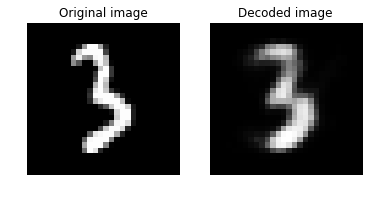

In [13]:
# Plot the original and the decoded image
img1 = orig_image.reshape(28,28)
text1 = 'Original image'

img2 = decoded_image.reshape(28,28)
text2 = 'Decoded image'

plot_image_pair(img1, text1, img2, text2)

## Создание модели (Deep AE)

Нам не нужно ограничиваться одним слоем как кодер или декодер, вместо этого мы могли бы использовать стек плотных слоев. Создадим глубокий автокодер.

In [14]:
# Рисунок 3
Image(url="http://cntk.ai/jup/DeepAEfig.jpg", width=500, height=300)

Размеры кодирования составляют 128, 64 и 32, в то время как размеры декодирования симметрично противоположны 64, 128 и 784. Это увеличивает количество параметров, используемых для моделирования преобразования, и обеспечивает более низкие частоты ошибок за счет более длительной продолжительности обучения и объема памяти. Если мы будем обучать этот глубокий энкодер для большего числа итераций, повернув флаг `isFast` как `False`, мы получим более низкую ошибку, а восстановленные изображения также немного лучше. 

In [15]:
input_dim = 784
encoding_dims = [128,64,32]
decoding_dims = [64,128]

encoded_model = None

def create_deep_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform()):
        encode = C.element_times(C.constant(1.0/255.0), features)

        for encoding_dim in encoding_dims:
            encode = C.layers.Dense(encoding_dim, activation = C.relu)(encode)

        global encoded_model
        encoded_model= encode
        
        decode = encode
        for decoding_dim in decoding_dims:
            decode = C.layers.Dense(decoding_dim, activation = C.relu)(decode)

        decode = C.layers.Dense(input_dim, activation = C.sigmoid)(decode)
        return decode  

In [16]:
num_label_classes = 15
reader_train = create_reader(train_file, True, input_dim, num_label_classes)
reader_test = create_reader(test_file, False, input_dim, num_label_classes)

model, deep_ae_train_error, deep_ae_test_error = train_and_test(reader_train, 
                                                                reader_test, 
                                                                model_func = create_deep_model) 

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per 1 samples: 3e-05
      544        544       0.75       0.75            64
      544        544      0.771      0.781           192
      544        543       0.78      0.786           448
      543        542      0.789      0.797           960
      530        518      0.863      0.933          1984
      415        303       0.77      0.679          4032
      315        216      0.624       0.48          8128
      258        203        0.5      0.376         16320
      215        171      0.366      0.234         32704
      176        137      0.251      0.136         65472
      145        115      0.165     0.0782        131008
      122       98.8      0.107     0.0486        262080
Average training error: 9.78%
Average test error: 3.19%


## Визуализация результатов глубокого AE

In [17]:
# Run the same image as the simple autoencoder through the deep encoder
orig_image = img_data[idx,:,:]
decoded_image = model.eval(orig_image)[0]*255

# Print image statistics
def print_image_stats(img, text):
    print(text)
    print("Max: {0:.2f}, Median: {1:.2f}, Mean: {2:.2f}, Min: {3:.2f}".format(np.max(img),
                                                                              np.median(img),
                                                                              np.mean(img),
                                                                              np.min(img))) 
    
# Print original image
print_image_stats(orig_image, "Original image statistics:")

# Print decoded image
print_image_stats(decoded_image, "Decoded image statistics:")


Original image statistics:
Max: 255.00, Median: 0.00, Mean: 24.07, Min: 0.00
Decoded image statistics:
Max: 250.87, Median: 0.03, Mean: 24.76, Min: 0.00


Давайте построим оригинальное и декодированное изображение с помощью глубокого автокодера. Они должны выглядеть визуально одинаковыми.

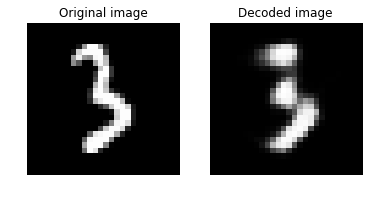

In [18]:
# Plot the original and the decoded image
img1 = orig_image.reshape(28,28)
text1 = 'Original image'

img2 = decoded_image.reshape(28,28)
text2 = 'Decoded image'

plot_image_pair(img1, text1, img2, text2)

Мы показали, как кодировать и декодировать ввод. В этом разделе мы рассмотрим как мы можем сравнивать друг с другом, а также как извлечь закодированный вход для данного ввода. Для визуализации высокоразмерных данных в 2D, [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) вероятно, является одним из лучших методов. Однако для этого обычно требуются относительно низкоразмерные данные. Поэтому хорошей стратегией визуализации отношений подобия в высокоразмерных данных является кодирование данных в низкоразмерном пространстве (например, 32-мерное) с использованием автокодера сначала, извлечение кодировки входных данных с последующим использованием t-SNE  для отображения сжатых данных в двумерную плоскость. 

Мы будем использовать выходы глубокого автокодера:
- Сравнивать два изображения и
- Показыватьь, как мы можем получить закодированные (сжатые) данные.

Сначала нам нужно прочитать некоторые данные изображения вместе с их метками.

In [19]:
# Read some data to run get the image data and the corresponding labels
num_label_classes = 10
reader_viz = create_reader(test_file, False, input_dim, num_label_classes)

image = C.input_variable(input_dim)
image_label = C.input_variable(num_label_classes)

viz_minibatch_size = 50

viz_input_map = { 
    image  : reader_viz.streams.features, 
    image_label  : reader_viz.streams.labels_viz 
}    
    
viz_data = reader_eval.next_minibatch(viz_minibatch_size,
                                  input_map = viz_input_map)

img_data   = viz_data[image].asarray()
imglabel_raw = viz_data[image_label].asarray()

In [20]:
# Map the image labels into indices in minibatch array
img_labels = [np.argmax(imglabel_raw[i,:,:]) for i in range(0, imglabel_raw.shape[0])]       
        
from collections import defaultdict
label_dict=defaultdict(list)
for img_idx, img_label, in enumerate(img_labels):
    label_dict[img_label].append(img_idx)        
    
# Print indices corresponding to 3 digits
randIdx = [1, 3, 9]
for i in randIdx:
    print("{0}: {1}".format(i, label_dict[i]))

1: [7, 24, 39, 44, 46]
3: [1, 13, 18, 26, 37, 40, 43]
9: [8, 12, 23, 28, 42, 49]


We will [compute cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity) between two images using `scipy`. 

In [21]:
from scipy import spatial

def image_pair_cosine_distance(img1, img2):
    if img1.size != img2.size:
        raise ValueError("Two images need to be of same dimension")
    return 1 - spatial.distance.cosine(img1, img2)

Distance between two original image: 0.294
Distance between two decoded image: 0.328


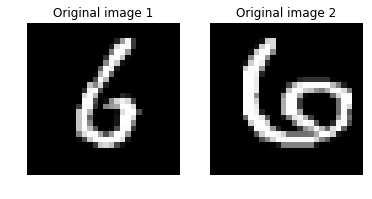

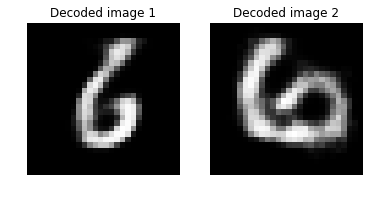

In [22]:
# Let s compute the distance between two images of the same number
digit_of_interest = 6

digit_index_list = label_dict[digit_of_interest]

if len(digit_index_list) < 2:
    print("Need at least two images to compare")
else:
    imgA = img_data[digit_index_list[0],:,:][0] 
    imgB = img_data[digit_index_list[1],:,:][0]
    
    # Print distance between original image
    imgA_B_dist = image_pair_cosine_distance(imgA, imgB)
    print("Distance between two original image: {0:.3f}".format(imgA_B_dist))
    
    # Plot the two images
    img1 = imgA.reshape(28,28)
    text1 = 'Original image 1'

    img2 = imgB.reshape(28,28)
    text2 = 'Original image 2'

    plot_image_pair(img1, text1, img2, text2)
    
    # Decode the encoded stream 
    imgA_decoded =  model.eval([imgA])[0]
    imgB_decoded =  model.eval([imgB])   [0]    
    imgA_B_decoded_dist = image_pair_cosine_distance(imgA_decoded, imgB_decoded)

    # Print distance between original image
    print("Distance between two decoded image: {0:.3f}".format(imgA_B_decoded_dist))
    
    # Plot the two images
    # Plot the original and the decoded image
    img1 = imgA_decoded.reshape(28,28)
    text1 = 'Decoded image 1'

    img2 = imgB_decoded.reshape(28,28)
    text2 = 'Decoded image 2'

    plot_image_pair(img1, text1, img2, text2)

Примечание: Косинус расстояние между исходными изображениями, сравнимыми с расстоянием между соответствующими декодированными изображениями. Значение 1 указывает на высокое сходство между изображениями и 0 означает отсутствие сходства.

Давайте посмотрим, как получить кодированный вектор, соответствующий входному изображению. Это должно иметь размер точки заслонки в сети, показанной на рисунке, с полем, обозначенным буквой `E`.

In [23]:
imgA = img_data[digit_index_list[0],:,:][0] 
imgA_encoded =  encoded_model.eval([imgA])

print("Length of the original image is {0:3d} and the encoded image is {1:3d}".format(len(imgA), 
                                                                                      len(imgA_encoded[0])))
print("\nThe encoded image: ")
print(imgA_encoded[0])

Length of the original image is 784 and the encoded image is  32

The encoded image: 
[ 11.82777977   4.2463069    9.04645538   8.06909943   0.          12.10138416
  24.50163841  22.81308746  17.6485424    0.           0.          25.21560097
  17.95014191  15.85327148  14.81459904  13.8848505   20.05287933
  15.64199352   5.09397745  19.44846725   9.97392941  25.279356
  14.46046925  11.2520628    8.5930748    0.          11.51117039
  18.61786079   8.75617695  13.50009632  15.16327667  15.76924419]


Давайте сравним расстояние между разными цифрами.

Distance between two original image: 0.376
Distance between two decoded image: 0.398


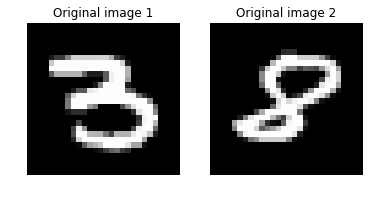

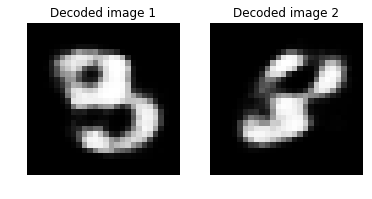

In [24]:
digitA = 3
digitB = 8

digitA_index = label_dict[digitA]
digitB_index = label_dict[digitB]

imgA = img_data[digitA_index[0],:,:][0] 
imgB = img_data[digitB_index[0],:,:][0]

# Print distance between original image
imgA_B_dist = image_pair_cosine_distance(imgA, imgB)
print("Distance between two original image: {0:.3f}".format(imgA_B_dist))
    
# Plot the two images
img1 = imgA.reshape(28,28)
text1 = 'Original image 1'

img2 = imgB.reshape(28,28)
text2 = 'Original image 2'

plot_image_pair(img1, text1, img2, text2)
    
# Decode the encoded stream 
imgA_decoded =  model.eval([imgA])[0]
imgB_decoded =  model.eval([imgB])[0]    
imgA_B_decoded_dist = image_pair_cosine_distance(imgA_decoded, imgB_decoded)

#Print distance between original image
print("Distance between two decoded image: {0:.3f}".format(imgA_B_decoded_dist))

# Plot the original and the decoded image
img1 = imgA_decoded.reshape(28,28)
text1 = 'Decoded image 1'

img2 = imgB_decoded.reshape(28,28)
text2 = 'Decoded image 2'

plot_image_pair(img1, text1, img2, text2)

Распечатайте результаты тестовой ошибки глубокого кодирования для регрессионного тестирования

In [25]:
# Simple autoencoder test error
print(simple_ae_test_error)

3.0350973549


In [26]:
# Deep autoencoder test error
print(deep_ae_test_error)

3.19201508


**Дополнительные задания**

- Попробуйте различные функции активации.
- Найдите, какие изображения больше похожи друг на друга (a), используя оригинальное изображение и (b) декодированное изображение.
- Попробуйте использовать среднюю квадратную ошибку в качестве функции потерь. Улучшает ли производительность кодировщик с точки зрения сокращения ошибок.
- Можете ли вы попробовать другую структуру сети, чтобы еще больше уменьшить ошибку. Объясните свои наблюдения.
- Можете ли вы использовать другую метрику расстояния для вычисления сходства между изображениями MNIST.
- Попробуйте использовать глубокий кодировщик с [1000, 500, 250, 128, 64, 32]. Какова ошибка обучения для такого же количества итераций?